In [9]:
import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
import itertools
from glob import glob
from scipy.stats import f_oneway
from pingouin import plot_paired
import warnings
from scipy.stats import ttest_rel

A couple of useful support functions. 

In [3]:
def get_stats(df: pd.DataFrame, y_col: str, method_list: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate R^2 and RMSE statistics for each method in the method list.

    :param df: The input DataFrame containing the data.
    :type df: pd.DataFrame
    :param y_col: The name of the column containing the true values.
    :type y_col: str
    :param method_list: A list of method names to evaluate.
    :type method_list: list[str]
    :return: Two DataFrames containing the R^2 and RMSE values for each method.
    :rtype: tuple[pd.DataFrame, pd.DataFrame]
    """
    r2_list = []
    rmse_list = []
    for k, v in df.groupby("fold"):
        r2_list.append([r2_score(v[y_col], v[x]) for x in method_list])
        rmse_list.append([root_mean_squared_error(v[y_col], v[x]) for x in method_list])
    r2_df = pd.DataFrame(r2_list, columns=method_list)
    rmse_df = pd.DataFrame(rmse_list, columns=method_list)
    r2_melt_df = r2_df.melt()
    r2_melt_df.columns = ["method", "r2"]
    rmse_melt_df = rmse_df.melt()
    rmse_melt_df.columns = ["method", "rmse"]
    return r2_melt_df, rmse_melt_df

def run_anova(df_in, col):
    res_list = []
    for k,v in df_in.groupby("method"):
        res_list.append(v[col].values)
    return f_oneway(*res_list)[1]

Compare molecular descriptors and ML models on the [Polaris biogen/adme-fang-v1](https://polarishub.io/datasets/biogen/adme-fang-v1) dataset.  The benchmark was run using the script **run_benchmark.py** in this repo.  

The figures below compare 8 model/descriptor combinations. 

lgbm_prop - [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) with RDKit properties    
lgbm_osm - [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) with [Osmordred](https://github.com/osmoai/osmordred) properties   
lgbm_morgan - [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) with [RDkit Morgan Fingerprints](https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html)  

xgb_prop - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html) with RDKit properties  
xgb_osm - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html) with [Osmordred](https://github.com/osmoai/osmordred) properties   
xgb_morgan - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html) with [RDkit Morgan Fingerprints](https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html)  

tabpfn - [TabPFN](https://github.com/PriorLabs/TabPFN) with RDKit proprties  
chemprop - [ChemProp](https://chemprop.readthedocs.io/en/latest/) with default parameters  

In plots below show a concise method of comparing predicitions from ML models. These plots use Tukey's Honestly Significant Difference (HSD) test and are based on code in [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.sandbox.stats.multicomp.TukeyHSDResults.plot_simultaneous.html). 
- The ML method with the largest mean $R^2$ or the smallest RMSE is shown in **blue**.
- Methods that are equivalent to the "best" model are shown in **grey**.
- Methods where there is statistically significant difference with the "best" model are shown in **red**.
- The bars associated with each method show the confidence intervals adjusted for multiple comparisons.
- Dashed vertical lines are drawn around the confidence intervals for the "best" method.

Here's an example showing 8 models calculated with the same train/test splits over 5x5-fold cross validation using the Human Plasma Protein Binding dataset from the Polaris [biogen/adme-fang-v1](https://polarishub.io/datasets/biogen/adme-fang-v1) dataset.   
<img src="ML_comparison_plots.png" alt="drawing" width="600"/>

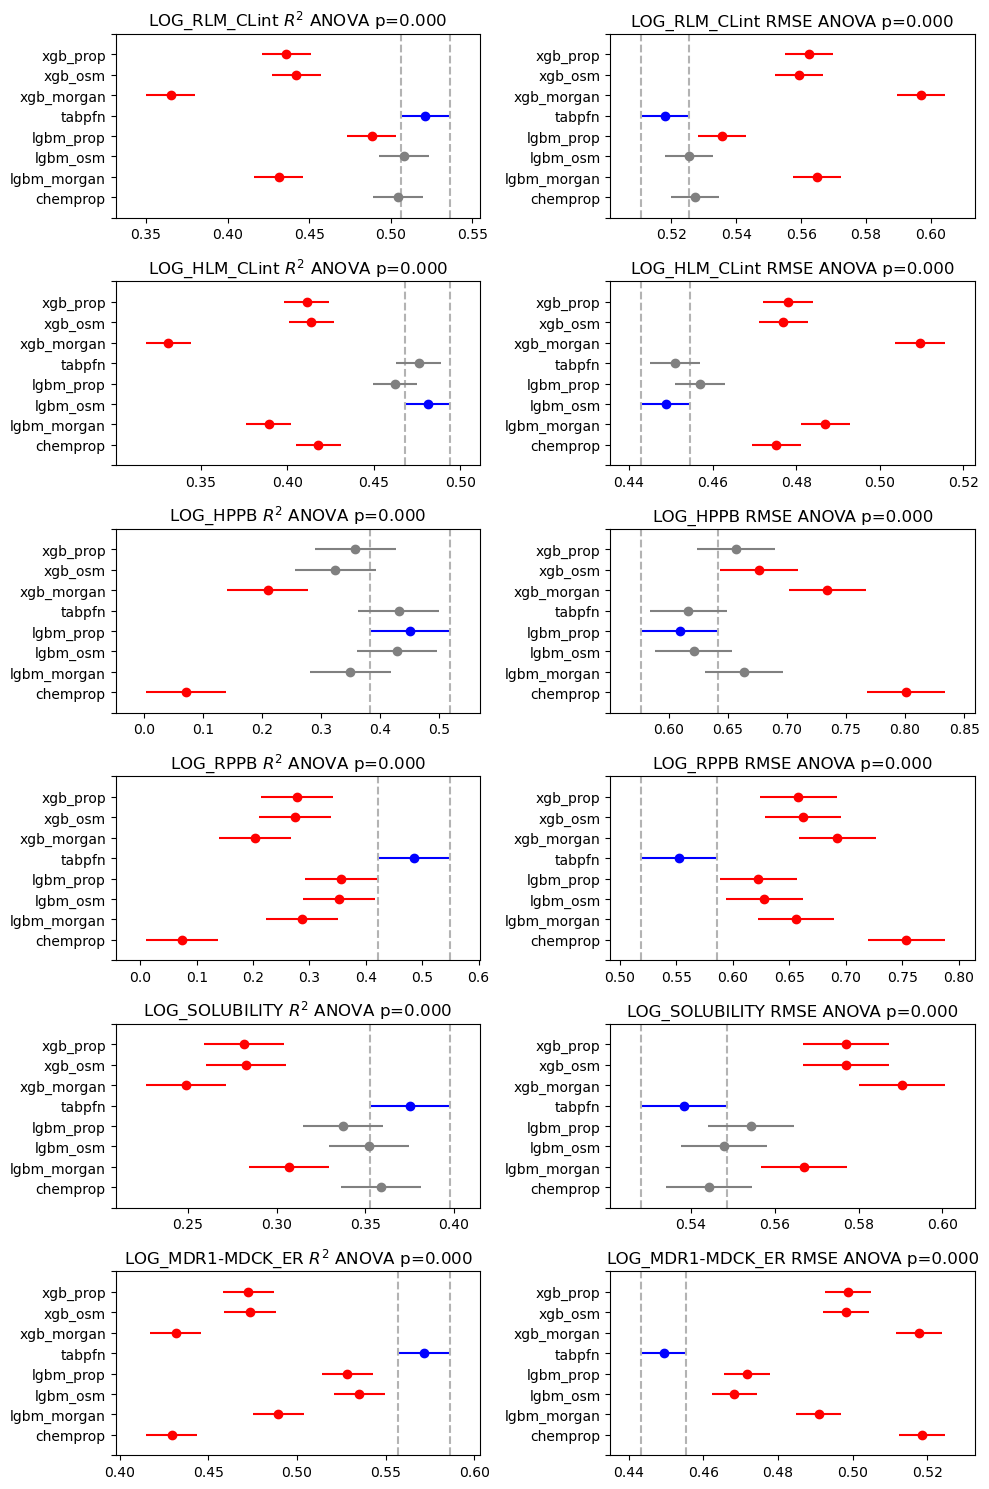

In [4]:
assay_list = [x.replace("_results.csv","") for x in glob("*results.csv")]
figure, axes = plt.subplots(len(assay_list),2,figsize=(10,100))
axes = axes.flatten()
df_list = []
for idx,assay_name in enumerate(assay_list):
    input_df = pd.read_csv(f"{assay_name}_results.csv")
    method_list = ['chemprop','lgbm_prop', 'lgbm_osm','lgbm_morgan','xgb_prop', 'xgb_osm', 'xgb_morgan','tabpfn']
    input_df = input_df[method_list+["dset","group","fold",assay_name]]
    test_df = input_df.query("dset == 'test' and group == 'random'")
    r2_melt_df, rmse_melt_df = get_stats(test_df,assay_name, method_list)
    df_list.append([assay_name, r2_melt_df.copy(), rmse_melt_df.copy()])
    best_r2 = r2_melt_df.groupby("method").mean().reset_index().sort_values("r2",ascending=False).method.values[0]
    tukey = pairwise_tukeyhsd(endog=r2_melt_df["r2"], groups=r2_melt_df["method"], alpha=0.05)
    current_axis = axes[idx*2]
    tukey.plot_simultaneous(comparison_name=best_r2,ax=current_axis,figsize=(10,15))
    r2_anova_p_value = run_anova(r2_melt_df,"r2")
    current_axis.set_title(assay_name+" $R^2$ "+ f"ANOVA p={r2_anova_p_value:.3f}")

    best_rmse = rmse_melt_df.groupby("method").mean().reset_index().sort_values("rmse",ascending=True).method.values[0]
    tukey = pairwise_tukeyhsd(endog=rmse_melt_df["rmse"], groups=rmse_melt_df["method"], alpha=0.05)
    current_axis = axes[idx*2+1]
    tukey.plot_simultaneous(comparison_name=best_rmse,ax=current_axis,figsize=(10,15))
    rmse_anova_p_value = run_anova(rmse_melt_df,"rmse")
    current_axis.set_title(assay_name+" RMSE "+f"ANOVA p={rmse_anova_p_value:.3f}")
plt.tight_layout()

Make a paired plot with [pingouin](https://pingouin-stats.org/build/html/index.html) to compare **lgbm_osm** and **tab_pfn**.  Titles are shown in red when the p-value for a paired t-test is <= 0.05.

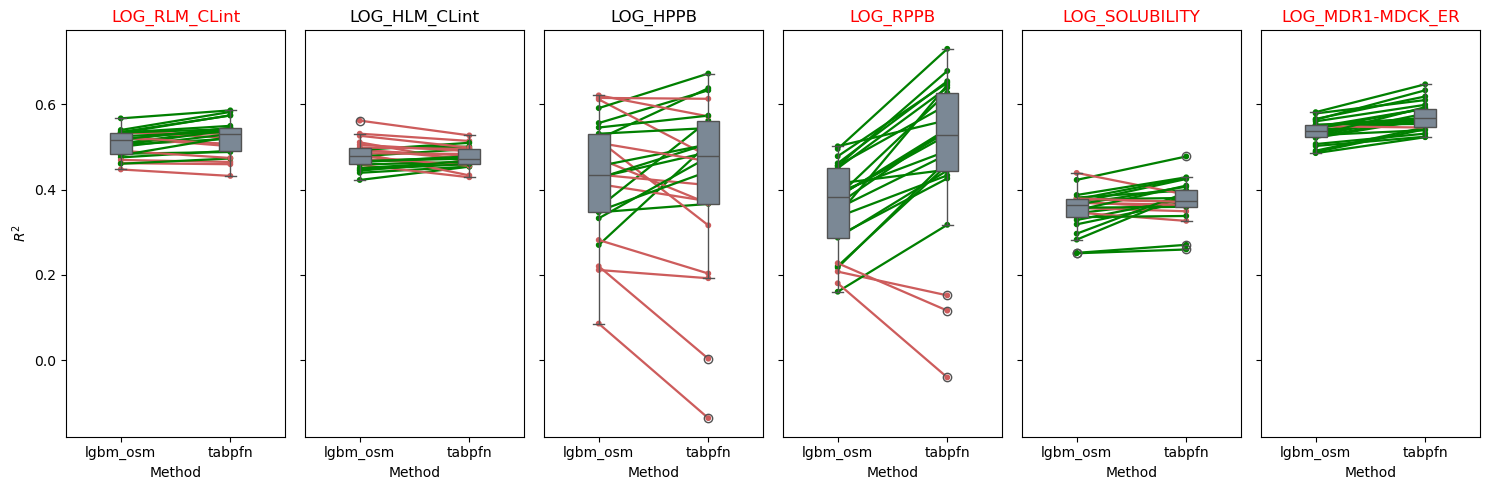

In [22]:
figure, axes = plt.subplots(1,6,figsize=(15,5),sharey=True)
axes.flatten()
for i in range(0,len(df_list)):
    cycle_list = list(range(0,25))*len(df_list[0][1].method.unique())
    df_list[i][1]['cycle'] = cycle_list
    method_list = ["lgbm_osm","tabpfn"]
    tmp_df = df_list[i][1].query("method in @method_list")
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=FutureWarning)
        ax = plot_paired(data=tmp_df,dv="r2",within="method",subject="cycle",ax=axes[i])
    r2_list = []
    for method in method_list:
        r2_list.append(tmp_df.query("method == @method").r2)   
    p_value = ttest_rel(r2_list[0],r2_list[1]).pvalue
    title_color = 'black'
    if p_value <= 0.05:
        title_color = 'red'
    ax.set_title(df_list[i][0],color=title_color)
    ax.set_xlabel("Method")
    ax.set_ylabel("$R^2$")
plt.tight_layout()